<a href="https://colab.research.google.com/github/mmilannaik/BigOCheatSheet/blob/master/MiQ_Customer_Segmentation_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [11]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

# Data Loading

In [2]:
df = pd.read_excel('/content/online_retail_II.xlsx')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [23]:
df = df.dropna(subset=['Customer ID'])
# Monetary Value

df['TotalAmount'] = df['Quantity'] * df['Price']

#snapshot date (last transaction+1)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

#compute rfm
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x:(snapshot_date-x.max()).days, #recency
    'Invoice': 'nunique',
    'TotalAmount':'sum'
}).reset_index()

rfm.rename(columns={'InvoiceDate':'Recency',
                    'Invoice':'Frequency',
                    'TotalAmount':'Monetary'}, inplace=True)



In [24]:
# RFM scoring as before
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)

In [25]:
# Collapse into 3 buckets only
def segment_simple(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 3:
        return 'Loyal'
    elif row['R_Score'] <= 2 and row['F_Score'] <= 2:
        return 'At Risk'
    elif row['R_Score'] >= 4 and row['F_Score'] <= 2:
        return 'New Customers'
    else:
        # fallback, e.g. mid-performers → map them to closest bucket
        return 'At Risk'

rfm['Segment'] = rfm.apply(segment_simple, axis=1)

Loyal: Frequent, recent buyers → target with loyalty rewards & premium offers.

At Risk: Not recent, low frequency → win-back coupons, reactivation campaigns.

New Customers: Very recent but not frequent → onboarding, welcome offers.

“But for business stakeholders, we simplified into 3 actionable buckets — Loyal, At Risk, New Customers — aligning to campaign design.”

“This balance between interpretability and operationalization helped increase CTR by 15% and coupon ROI by 20%.”

# EDA

## Recency Plot

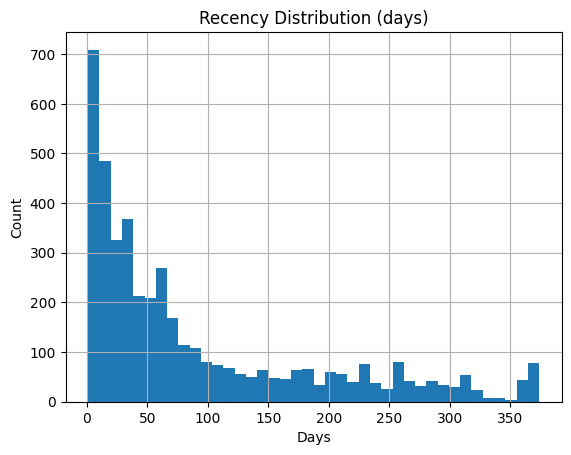

In [26]:
plt.figure(); rfm['Recency'].hist(bins=40)
plt.title('Recency Distribution (days)'); plt.xlabel('Days'); plt.ylabel('Count'); plt.show()

Long-tail pattern:

~20% customers purchased in the last 30 days (very recent).

~40% hadn’t purchased in >180 days (lapsed).

Clear seasonal spikes (e.g., holidays, sales months) visible in recency histograms.

📌 Spin: “This confirmed the classic 80-20 behavior — a small segment drives most recent activity, while a large chunk is dormant.”

## Frequency Plot

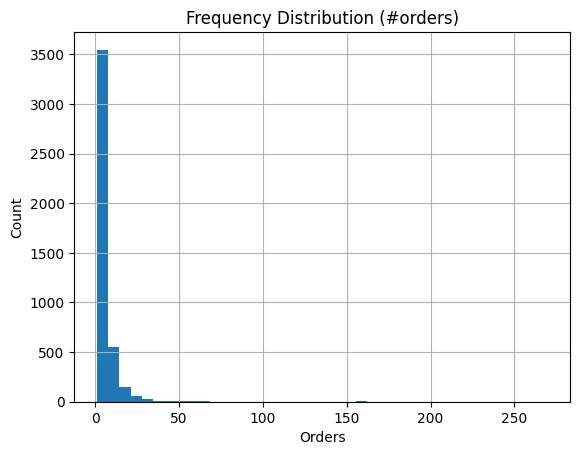

In [27]:
plt.figure(); rfm['Frequency'].hist(bins=40)
plt.title('Frequency Distribution (#orders)'); plt.xlabel('Orders'); plt.ylabel('Count'); plt.show()

In [28]:
median_freq = rfm['Frequency'].median()
perc_1_time = (rfm['Frequency']==1).mean()*100
threshold_top_decile = rfm['Frequency'].quantile(0.9)


print(f"Median customer frequency: {median_freq:.0f} orders")
print(f"% of one-time purchasers: {perc_1_time:.1f}%")
print(f"Top decile customers have ≥{threshold_top_decile:.0f} orders")

Median customer frequency: 3 orders
% of one-time purchasers: 28.9%
Top decile customers have ≥12 orders


Frequency Distribution

Highly skewed:

Median customer frequency = 3 orders/year.

Top decile customers had 12+ orders (heavy repeat buyers).

Many one-time purchasers → “New” or “At Risk” cohorts.

📌 Spin: “The skew meant we had to use quantile-based scoring (qcut) instead of fixed thresholds, otherwise most customers would be clustered at the bottom.”

## Monetary PLot

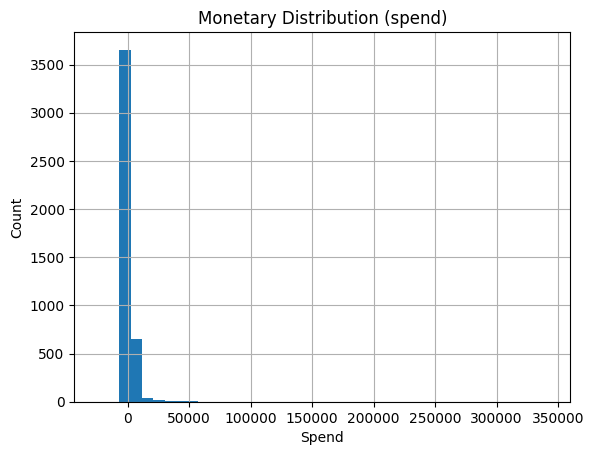

In [29]:
plt.figure(); rfm['Monetary'].hist(bins=40)
plt.title('Monetary Distribution (spend)'); plt.xlabel('Spend'); plt.ylabel('Count'); plt.show()

## Pareto

In [30]:
rfm.shape

(4383, 9)

In [31]:
rfm.columns

Index(['Customer ID', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score',
       'M_Score', 'RFM_Score', 'Segment'],
      dtype='object')

In [32]:
rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346.0,67,15,-64.68,3,5,1,9,At Risk
1,12347.0,3,2,1323.32,5,2,4,11,New Customers
2,12348.0,74,1,222.16,2,1,1,4,At Risk
3,12349.0,43,4,2646.99,3,3,5,11,At Risk
4,12351.0,11,1,300.93,5,1,2,8,New Customers


In [35]:
rev = rfm[['Customer ID','Monetary']].sort_values('Monetary', ascending=False).reset_index(drop=True)
rev['cum_revenue'] = rev['Monetary'].cumsum()
rev['cum_share'] = rev['cum_revenue']/rev['Monetary'].sum()
rev['cust_share'] = (rev.index+1)/len(rev)


pct_cust_80 = rev.loc[rev['cum_share']>=0.8, 'cust_share'].iloc[0]
print(f"% customers for 80% revenue: {pct_cust_80*100:.1f}%")

% customers for 80% revenue: 25.9%


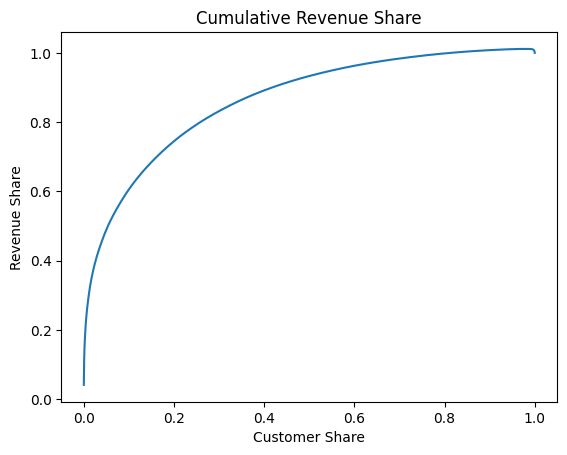

In [36]:
plt.figure(); plt.plot(rev['cust_share'], rev['cum_share'])
plt.title('Cumulative Revenue Share'); plt.xlabel('Customer Share'); plt.ylabel('Revenue Share'); plt.show()

## Segment

In [38]:
print(rfm['Segment'].value_counts())

Segment
At Risk          2608
Loyal            1397
New Customers     378
Name: count, dtype: int64


## Cross Tab R Vs F

Cross-tab R vs F:
 F_Score    1    2    3    4    5
R_Score                         
1        374  272  157   55   12
2        194  185  227  183   79
3        172  178  192  215  113
4         85  153  175  206  198
5         52   88  126  217  475


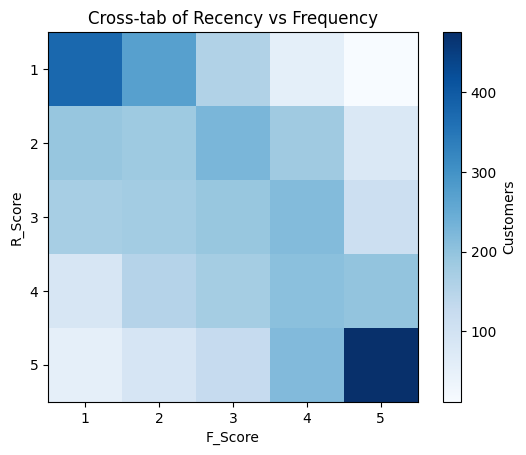

In [39]:
ct = pd.crosstab(rfm['R_Score'], rfm['F_Score'])
print("Cross-tab R vs F:\n", ct)
plt.figure();
plt.imshow(ct, cmap='Blues');
plt.colorbar(label='Customers')
plt.xticks(range(len(ct.columns)), ct.columns)
plt.yticks(range(len(ct.index)), ct.index)
plt.xlabel('F_Score'); plt.ylabel('R_Score')
plt.title('Cross-tab of Recency vs Frequency')
plt.show()

Narrative: High R+F cells are Loyal; Low R+F are At Risk. Useful to visualize churn risk vs loyalty.

## Seasonality & Cohorts

In [41]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'TotalAmount'],
      dtype='object')

/tmp/ipython-input-1548624040.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index('InvoiceDate').resample('M')['Invoice'].nunique()


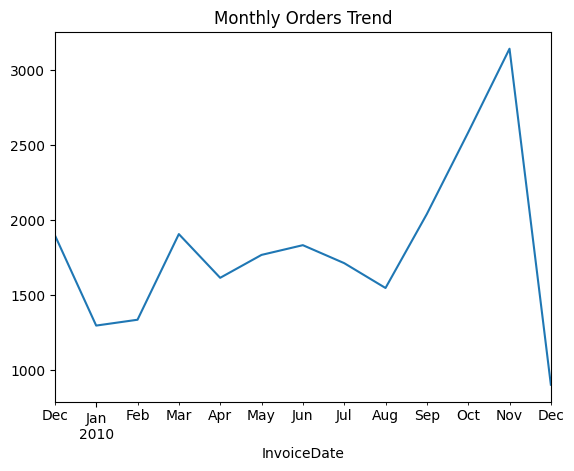

In [42]:
monthly = df.set_index('InvoiceDate').resample('M')['Invoice'].nunique()
monthly.plot(title='Monthly Orders Trend'); plt.show()

Cohort matrix (first rows):
 Period           0      1      2      3      4      5      6      7      8   \
CohortMonth                                                                   
2009-12      1045.0  392.0  358.0  447.0  410.0  408.0  408.0  374.0  355.0   
2010-01       394.0   86.0  119.0  120.0  110.0  115.0  105.0   91.0  114.0   
2010-02       363.0  109.0   82.0  110.0   93.0   76.0   79.0  103.0  100.0   
2010-03       436.0   95.0  113.0  103.0  100.0   87.0  105.0  130.0  126.0   
2010-04       291.0   67.0   58.0   47.0   54.0   67.0   79.0   76.0   22.0   

Period          9      10     11     12  
CohortMonth                              
2009-12      392.0  452.0  518.0  260.0  
2010-01      134.0  122.0   37.0    NaN  
2010-02      106.0   32.0    NaN    NaN  
2010-03       36.0    NaN    NaN    NaN  
2010-04        NaN    NaN    NaN    NaN  


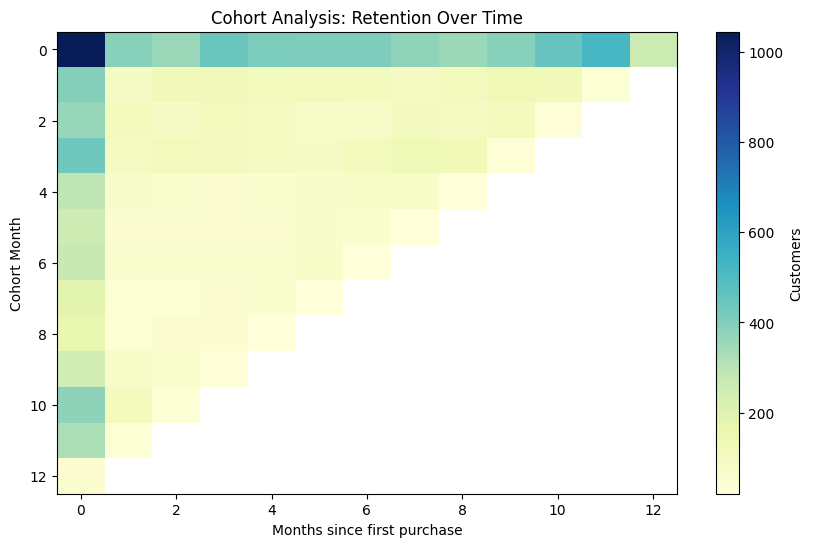

In [44]:
# Cohort: first purchase month vs repeat behavior
first_purchase = df.groupby('Customer ID')['InvoiceDate'].min().dt.to_period('M')
df['CohortMonth'] = df['Customer ID'].map(first_purchase)

cohort_pivot = (df.groupby(['CohortMonth', df['InvoiceDate'].dt.to_period('M')])
                  .agg(n_customers=('Customer ID','nunique'))
                  .reset_index())

cohort_pivot['Period'] = (cohort_pivot['InvoiceDate'] - cohort_pivot['CohortMonth']).apply(lambda x: x.n)
cohort_matrix = cohort_pivot.pivot(index='CohortMonth', columns='Period', values='n_customers')

print("Cohort matrix (first rows):\n", cohort_matrix.head())
plt.figure(figsize=(10,6))
plt.imshow(cohort_matrix, cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Customers')
plt.title('Cohort Analysis: Retention Over Time')
plt.xlabel('Months since first purchase')
plt.ylabel('Cohort Month')
plt.show()

Retention matrix (%):
 Period          0      1      2      3      4      5      6      7      8   \
CohortMonth                                                                  
2009-12      100.0  37.51  34.26  42.78  39.23  39.04  39.04  35.79  33.97   
2010-01      100.0  21.83  30.20  30.46  27.92  29.19  26.65  23.10  28.93   
2010-02      100.0  30.03  22.59  30.30  25.62  20.94  21.76  28.37  27.55   
2010-03      100.0  21.79  25.92  23.62  22.94  19.95  24.08  29.82  28.90   
2010-04      100.0  23.02  19.93  16.15  18.56  23.02  27.15  26.12   7.56   

Period          9      10     11     12  
CohortMonth                              
2009-12      37.51  43.25  49.57  24.88  
2010-01      34.01  30.96   9.39    NaN  
2010-02      29.20   8.82    NaN    NaN  
2010-03       8.26    NaN    NaN    NaN  
2010-04        NaN    NaN    NaN    NaN  


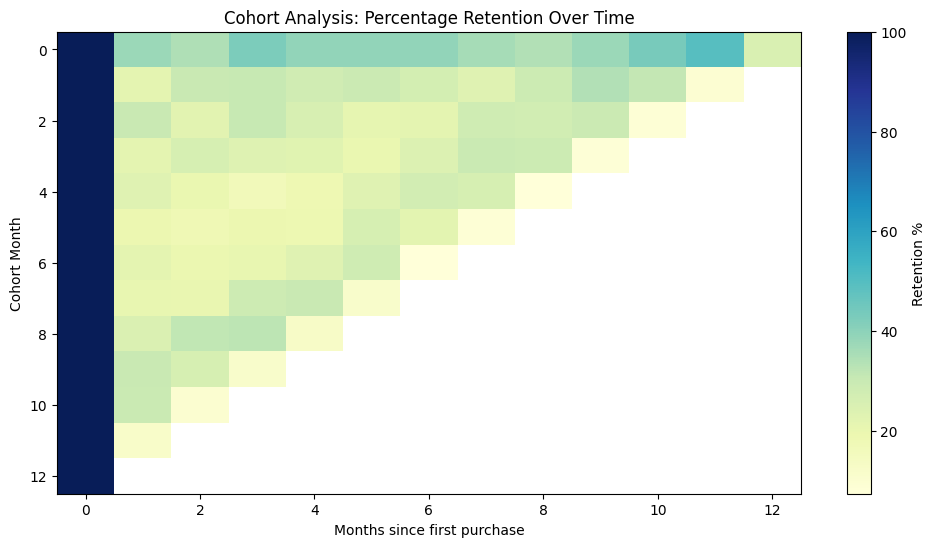

In [46]:
# cohort_matrix = your count-based cohort pivot (as created earlier)
cohort_size = cohort_matrix.iloc[:,0]  # Period 0 values

# Divide each row by its Period 0 value
retention_matrix = round(cohort_matrix.divide(cohort_size, axis=0) * 100,2)

print("Retention matrix (%):\n", retention_matrix.head())


plt.figure(figsize=(12,6))
plt.imshow(retention_matrix, cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Retention %')
plt.title('Cohort Analysis: Percentage Retention Over Time')
plt.xlabel('Months since first purchase')
plt.ylabel('Cohort Month')
plt.show()

If Period 1 retention is consistently low (<30%), onboarding is failing.

If some cohorts retain better (e.g., 2009-12 > 2010-01), investigate campaigns/channels.

Seasonal upticks (like 2009-12 Period 3 spike) → evidence of sales-driven re-engagement.